In [1]:
import numpy as np
import math
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
import cartopy
import cartopy.crs as ccrs
import metpy.calc as mpcalc
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
import pop_tools 
import matplotlib.path as mpath
import dask
import esmlab
import utils

### Look at transect from 30°S to 60°S along 180°W

In [2]:
case = 'g.e22.G1850ECO_JRA_HR.TL319_t13.004'
path = '/glade/campaign/cesm/development/bgcwg/projects/hi-res_JRA/cases/' + case + '/output/ocn/proc/tseries/month_1'
variables = ['Fe'] # ,'TEMP','SSH','O2','ALK','SALT','NO3']
coords = {'x':'TLONG','y':'TLAT'}
keep_vars = variables + list(coords.values())+['dz','KMT']

### get every 5 years 

In [7]:
%%time

ds_ann = xr.Dataset()

for year in [1,6,11,16,21,26,31]:
    yr4="{:02d}".format(year)
    #ds_list = []
    print(year)
    
    ds = xr.Dataset()

    for v in variables:  
        
        print(v)
        file = sorted(glob(f'{path}/{case}.pop.h.{v}.00{yr4}01-00{yr4}12.nc'))
        
        #dsv=xr.open_dataset(file, decode_times=True)
        dsv=xr.open_mfdataset(file, decode_times=True,drop_variables=["transport_components", "transport_regions"], 
                            parallel=True, compat="override", concat_dim="time",data_vars="minimal",coords='minimal' )
        print('got dsv')
        ds = xr.merge((ds, dsv))
        #ds_list.append(ds)
        

    ds = ds.drop([v for v in ds.variables if v not in keep_vars]).squeeze()
    print('monthly file', len(ds.time))
    ds = ds.mean(dim='time')
    ds_ann = xr.concat([ds_ann, ds], "time")
    #print('annual file', len(ds_ann.time))

1
Fe
got dsv
monthly file 12
6
Fe
got dsv
monthly file 12
11
Fe
got dsv
monthly file 12
16
Fe
got dsv
monthly file 12
21
Fe
got dsv
monthly file 12
26
Fe
got dsv
monthly file 12
31
Fe
got dsv
monthly file 12
CPU times: user 1.4 s, sys: 209 ms, total: 1.61 s
Wall time: 2.16 s


In [8]:
ds_ann.load()

<xarray.Dataset>
Dimensions:  (nlat: 2400, nlon: 3600, time: 7, z_t: 62)
Coordinates:
    TLONG    (time, nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan
    TLAT     (time, nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan
Dimensions without coordinates: nlat, nlon, time, z_t
Data variables:
    KMT      (time, nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan
    dz       (time, z_t) float32 1e+03 1e+03 1e+03 ... 2.5e+04 2.5e+04 2.5e+04
    Fe       (time, z_t, nlat, nlon) float32 nan nan nan nan ... nan nan nan nan

In [9]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='100GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=100GB',
        project='NCGD0011',
        walltime='02:00:00',
        interface='ib0',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })
    client = Client(cluster)
    return cluster, client

In [10]:
cluster, client = get_ClusterClient()
cluster.scale(5) 

In [11]:
client

Client Scheduler: tcp://10.12.206.15:37331 Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kristenk/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [12]:
ds_grid = pop_tools.get_grid('POP_tx0.1v3')

In [33]:
area = ds_grid.TAREA
lats = ds_grid.TLAT
lons = ds_grid.TLONG
depth = ds_grid.z_t * 0.01

ds_ann['TAREA']=ds_grid.TAREA
ds_ann['REGION_MASK']=ds_grid.REGION_MASK
ds_ann['time'] = [1,6,11,16,21,26,31]

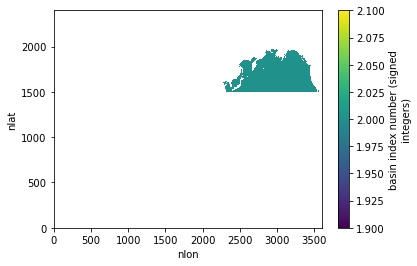

In [63]:
ds_ann.REGION_MASK.where(ds_ann.REGION_MASK == 2).where(lats > 30).plot()

### set up for plotting hovmoellers

In [45]:
depths_m = depth
z_top    = depths_m.isel(z_t=slice(0,40))
z_bottom = depths_m.isel(z_t=slice(40,60))
years    = ds_ann['time']

### Southern Ocean timeseries

In [52]:
%%time
ts_SO = xr.Dataset({v: ds_ann[v] for v in ['time','z_t']})
ts_SO['Fe'] = esmlab.weighted_mean(ds_ann['Fe'].where(lats<-30), weights=area, dim=['nlat', 'nlon']).compute()

ts_SO['Fe'] = ts_SO.Fe * 1000. #convert to nM
ts_SO['Fe'].attrs['units'] = 'nM'
#ts_SO['Fe']

CPU times: user 33.4 s, sys: 28.7 s, total: 1min 2s
Wall time: 1min


In [46]:
ts_SO_top=ts_SO.isel(z_t=slice(0,40)).transpose()
ts_SO_bot=ts_SO.isel(z_t=slice(40,60)).transpose()

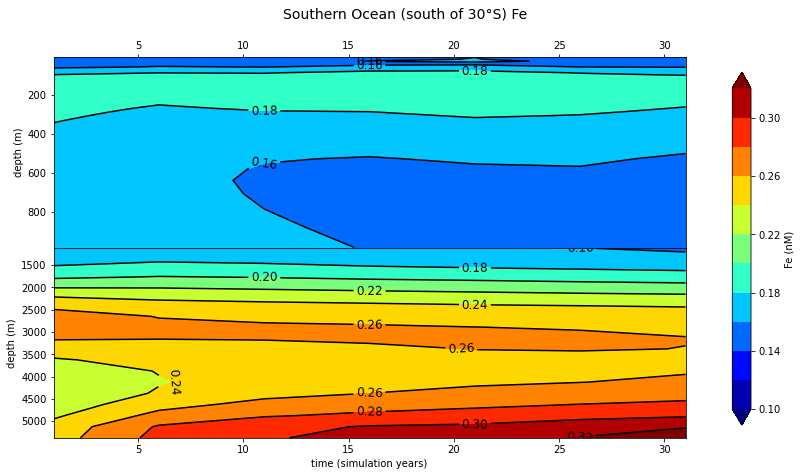

In [55]:
fig = plt.figure(figsize=(13,7))

plt.suptitle('Southern Ocean (south of 30°S) Fe', fontsize=14)

ax = fig.add_subplot(2,1,1)
levels = np.arange(0.1,0.34,0.02)
pc=ax.contourf(years, z_top, ts_SO_top['Fe'], levels, cmap='jet',extend='both')
contour = plt.contour(years, z_top, ts_SO_top['Fe'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.2f', fontsize=12)
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.invert_yaxis()
ax.xaxis.tick_top()

ax = fig.add_subplot(2,1,2)
pc=ax.contourf(years, z_bottom, ts_SO_bot['Fe'], levels, cmap='jet',extend='both')
contour = plt.contour(years, z_bottom, ts_SO_bot['Fe'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.2f', fontsize=12)
ax.set(ylabel='depth (m)', xlabel='time (simulation years)')
ax.invert_yaxis()

fig.subplots_adjust(right=0.8,hspace=0)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax, label='Fe (nM)',extend='both')

### Global timeseries

In [57]:
%%time
ts_glob = xr.Dataset({v: ds_ann[v] for v in ['time','z_t']})
ts_glob['Fe'] = esmlab.weighted_mean(ds_ann['Fe'], weights=area, dim=['nlat', 'nlon']).compute()

ts_glob['Fe'] = ts_glob.Fe * 1000. #convert to nM (from mmol/m3)
ts_glob['Fe'].attrs['units'] = 'nM'
#ts_SO['Fe']

CPU times: user 31.9 s, sys: 25.5 s, total: 57.5 s
Wall time: 55.9 s


In [58]:
ts_glob_top=ts_glob.isel(z_t=slice(0,40)).transpose()
ts_glob_bot=ts_glob.isel(z_t=slice(40,60)).transpose()

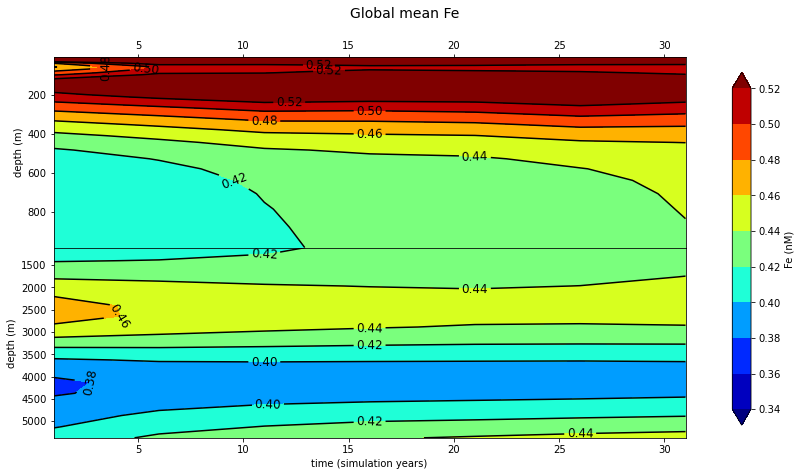

In [61]:
fig = plt.figure(figsize=(13,7))

plt.suptitle('Global mean Fe', fontsize=14)

ax = fig.add_subplot(2,1,1)
levels = np.arange(0.34,0.54,0.02)
pc=ax.contourf(years, z_top, ts_glob_top['Fe'], levels, cmap='jet',extend='both')
contour = plt.contour(years, z_top, ts_glob_top['Fe'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.2f', fontsize=12)
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.invert_yaxis()
ax.xaxis.tick_top()

ax = fig.add_subplot(2,1,2)
pc=ax.contourf(years, z_bottom, ts_glob_bot['Fe'], levels, cmap='jet',extend='both')
contour = plt.contour(years, z_bottom, ts_glob_bot['Fe'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.2f', fontsize=12)
ax.set(ylabel='depth (m)', xlabel='time (simulation years)')
ax.invert_yaxis()

fig.subplots_adjust(right=0.8,hspace=0)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax, label='Fe (nM)',extend='both')

### Now do North Pacific north of 30°N

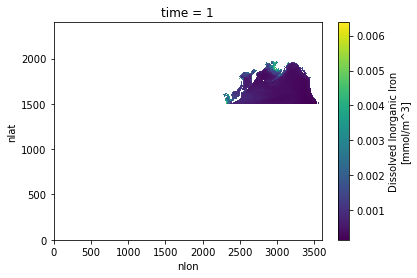

In [71]:
masked = ds_ann['Fe'].where(ds_ann.REGION_MASK == 2).where(lats > 30)
masked.isel(time=0,z_t=0).plot();

In [72]:
%%time
ts_npac = xr.Dataset({v: ds_ann[v] for v in ['time','z_t']})
ts_npac['Fe'] = esmlab.weighted_mean(masked, weights=area, dim=['nlat', 'nlon']).compute()

ts_npac['Fe'] = ts_npac.Fe * 1000. #convert to nM (from mmol/m3)
ts_npac['Fe'].attrs['units'] = 'nM'
#ts_SO['Fe']

CPU times: user 30.1 s, sys: 25.7 s, total: 55.9 s
Wall time: 54.3 s


In [73]:
ts_npac_top=ts_npac.isel(z_t=slice(0,40)).transpose()
ts_npac_bot=ts_npac.isel(z_t=slice(40,60)).transpose()

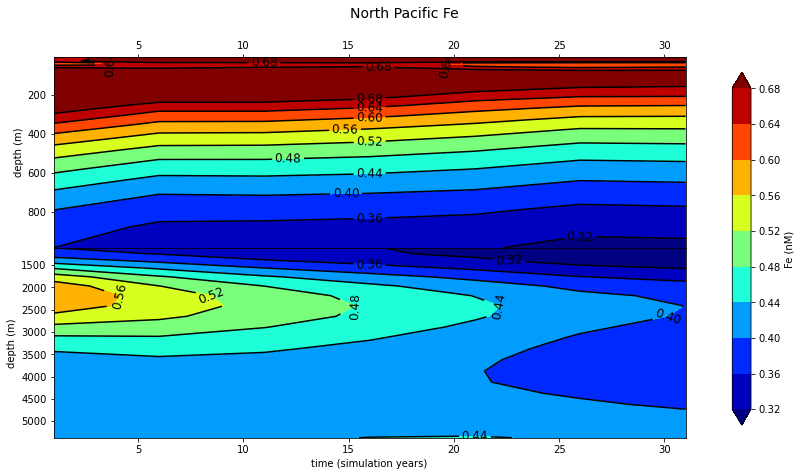

In [76]:
fig = plt.figure(figsize=(13,7))

plt.suptitle('North Pacific Fe', fontsize=14)

ax = fig.add_subplot(2,1,1)
levels = np.arange(0.32,0.72,0.04)
pc=ax.contourf(years, z_top, ts_npac_top['Fe'], levels, cmap='jet',extend='both')
contour = plt.contour(years, z_top, ts_npac_top['Fe'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.2f', fontsize=12)
ax.set(ylabel='depth (m)') #, xlabel='time (simulation years)')
ax.invert_yaxis()
ax.xaxis.tick_top()

ax = fig.add_subplot(2,1,2)
pc=ax.contourf(years, z_bottom, ts_npac_bot['Fe'], levels, cmap='jet',extend='both')
contour = plt.contour(years, z_bottom, ts_npac_bot['Fe'], levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.2f', fontsize=12)
ax.set(ylabel='depth (m)', xlabel='time (simulation years)')
ax.invert_yaxis()

fig.subplots_adjust(right=0.8,hspace=0)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax, label='Fe (nM)',extend='both')